In [1]:
# Load packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.metrics import mean_absolute_error,mean_squared_error

pi  = np.pi
cos = lambda x: np.cos(x)


In [2]:
#Define the brannin function with the typical parameters
def Brannin(x1,x2):
    a = 1 
    b = 5.1/(4*pi**2)
    c = 5/pi
    r = 6
    s = 10
    t = 1/(8*pi)
    return a*(x2-b * x1**2 + c*x1 - r)**2 + s*(1-t)*cos(x1) + s

In [3]:
# Define a mesh for exploration
x1 = np.linspace(-5,10,800)
x2 = np.linspace(0,15,800)

X1, X2 = np.meshgrid(x1,x2)

z = np.array([[Brannin(xx1,xx2) for xx1 in x1] for xx2 in x2]) 

In [4]:
# Since this is the same mesh we will use for testing the fitted model we will put it in a vector to compute the mean_sq_error

Xt = []
for xx1 in x1:
    for xx2 in x2:
        Xt.append([xx1,xx2])     
Xt = np.array(Xt)
YT = np.array([Brannin(xx1,xx2) for xx1,xx2 in Xt])

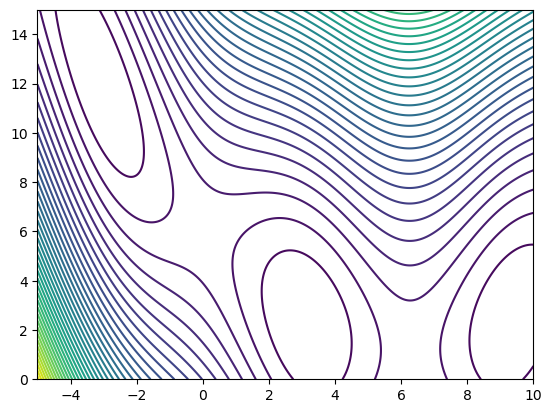

In [5]:
fig, ax = plt.subplots(1,1)
ax.contour(X1,X2,z,levels=50)

# Make a function to try the acquisition function

In [6]:
def test(acqfunc,NE,No,MSEs=None,gpr=None,plotting=False):
    # define seed for reproducibility
    np.random.seed(65)
    # Initial training
    tb = np.random.random((No,2))*15
    tb[:,0] = tb[:,0]-5

    tby = np.array([Brannin(xx1,xx2) for xx1,xx2 in tb])
    # First training
    if(gpr==None):
        kernel = 1.0 * RBF(length_scale=1e1, length_scale_bounds=(5e-1,1e2))
        gpr = GaussianProcessRegressor(kernel=kernel,alpha=2.0)
        gpr.fit(tb,tby)

    

    # Initial MSE
    Yp = gpr.predict(Xt)
    mse = mean_squared_error(YT,Yp)

    if(MSEs==None):
        MSEs = [mse]
    print("Initial MSE: ",mse)

    if(plotting):
            fig = plt.figure(figsize=(16,6))
            ax = fig.add_subplot(1,2,1)
            ax.plot(MSEs,'o')
            ax.set_xlabel('Added point from pretraining')
            ax.set_ylabel('MSE')
            zp = np.array([[gpr.predict([[xx1,xx2]])[0] for xx1 in x1] for xx2 in x2]) 
            ax = fig.add_subplot(1,2,2,projection='3d')
            ax.plot_surface(X1,X2,zp,cmap='turbo')
            ax.scatter3D(tb[:,0],tb[:,1],tby)
            plt.show()
            plt.close()
    #Extensive candidate list
    candidates = np.random.random((400,2))*15
    candidates[:,0] = candidates[:,0]-5

    #List the arrays
    tbl = list(tb)
    tbyl = list(tby)

    candl = list(candidates)
    for _ in range(NE):
        for i in range(10):
            acqfunc(candl,tbl,tbyl,gpr)
            Yp = gpr.predict(Xt)
            mse = mean_squared_error(YT,Yp)
            MSEs.append(mse)

        if(plotting):
            fig = plt.figure(figsize=(16,6))
            ax = fig.add_subplot(1,2,1)
            ax.plot(MSEs)
            ax.set_xlabel('Added point from pretraining')
            ax.set_ylabel('MSE')
            zp = np.array([[gpr.predict([[xx1,xx2]])[0] for xx1 in x1] for xx2 in x2]) 
            ax = fig.add_subplot(1,2,2,projection='3d')
            ax.plot_surface(X1,X2,zp,cmap='turbo')
            ax.scatter3D(np.array(tbl)[:,0],np.array(tbl)[:,1],tbyl)
            plt.show()
            plt.close()
            
    return MSEs, gpr, tbl, tbyl

# Defining an acquisition function based on greedy Sampling

In [7]:
# Greedy sampling function on feature space (just distance to nearest neighboor)
def GS_x(x,x_list):
    distances = np.zeros_like(x_list)

    for ii,xx in enumerate(x_list):
        distances[ii] = np.sum(np.abs(x-xx))
    return np.min(distances)

# Determine on a model what point from the list of candidates to add
def select_new_samples_single_episode(candidates, x_init, y_init, model):
    Gss = [GS_x(candidate,x_init) for candidate in candidates]
    cand = np.argmax(Gss)
    x_init.append(candidates[cand])
    y_init.append(Brannin(candidates[cand][0],candidates[cand][1]))
    candidates.pop(cand)
    model.fit(np.array(x_init),np.array(y_init))
    return None

In [82]:
# Data generation
# Generate a sample of a few points as the starting ground 
np.random.seed(15)
tb = np.random.random((8,2))*15
tb[:,0] = tb[:,0]-5

tby = np.array([Brannin(xx1,xx2) for xx1,xx2 in tb])

In [83]:
# Looking at the bottom for trying to fit using a single shot, showed this parameters for the kernel are appropriate.
#TODO: Is this a strike of luck? Is there a more systematic way to find these?

kernel = 1.0 * RBF(length_scale=1e1, length_scale_bounds=(5e-1,1e2))
gpr = GaussianProcessRegressor(kernel=kernel,alpha=2.0)
gpr.fit(tb,tby)

GaussianProcessRegressor(alpha=2.0, kernel=1**2 * RBF(length_scale=10))

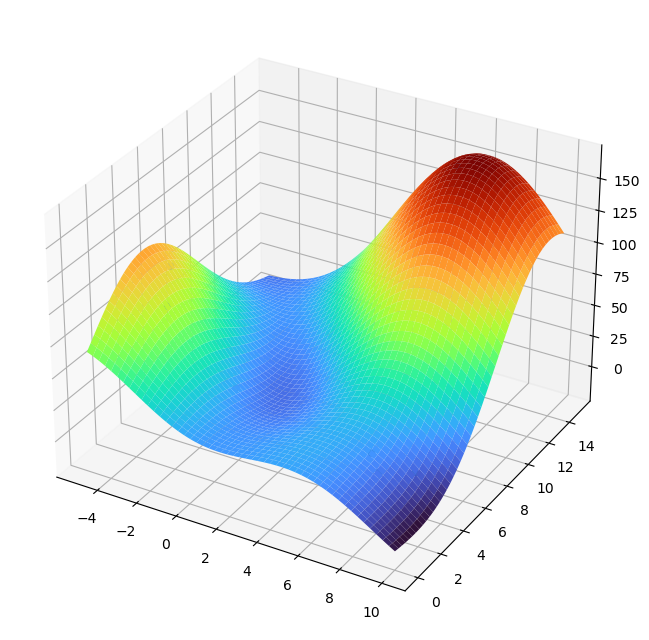

In [84]:
zp = np.array([[gpr.predict([[xx1,xx2]])[0] for xx1 in x1] for xx2 in x2]) 
fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(1,1,1,projection='3d')
ax.plot_surface(X1,X2,zp,cmap='turbo')
ax.scatter3D(tb[:,0],tb[:,1],tby)

In [85]:
# We will keep track of this metric
Yp = gpr.predict(Xt)
mse = mean_squared_error(YT,Yp)

MSEs = [mse]
print(mse)

636.8889149781771


In [86]:
# Generate a large pool of candidate points randomly distributed

candidates = np.random.random((400,2))*15
candidates[:,0] = candidates[:,0]-5

tbl = list(tb)
tbyl = list(tby)

candl = list(candidates)

for i in range(10):
    select_new_samples_single_episode(candl,tbl,tbyl,gpr)
    Yp = gpr.predict(Xt)
    mse = mean_squared_error(YT,Yp)

    MSEs.append(mse)

Text(0.5, 0, 'Number of points added over pretraining data')

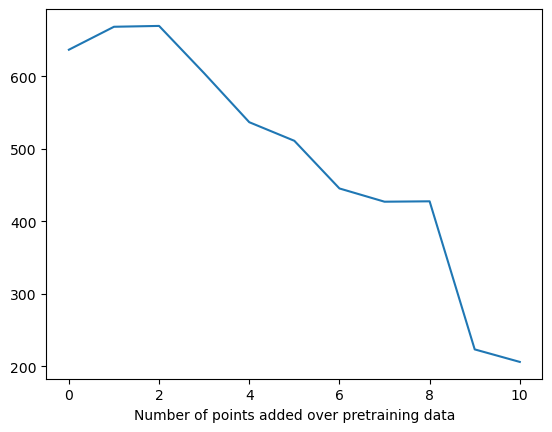

In [87]:
# See how the error evolves:
plt.plot(MSEs)
plt.xlabel('Number of points added over pretraining data')

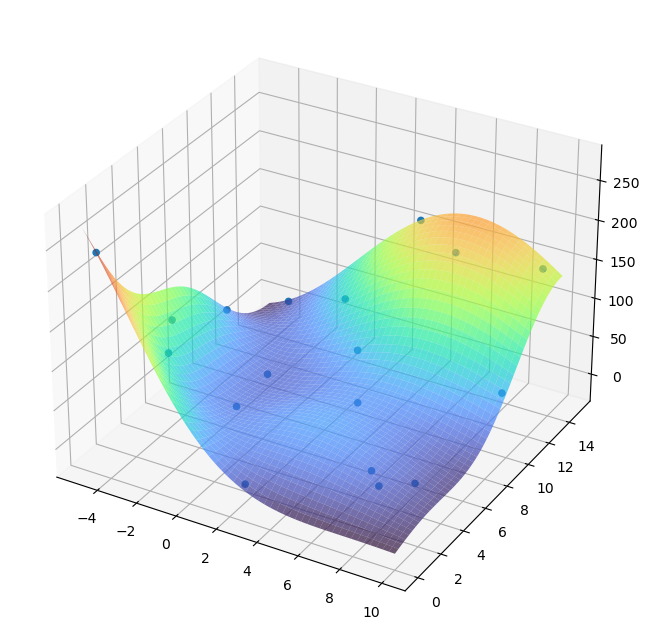

In [88]:
zp = np.array([[gpr.predict([[xx1,xx2]])[0] for xx1 in x1] for xx2 in x2]) 

fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(1,1,1,projection='3d')

ax.scatter3D(np.array(tbl)[:,0],np.array(tbl)[:,1],tbyl,alpha=1)
ax.plot_surface(X1,X2,zp,cmap='turbo',alpha=0.7)

In [89]:
# Add more candidates
for i in range(10):
    select_new_samples_single_episode(candl,tbl,tbyl,gpr)
    Yp = gpr.predict(Xt)
    mse = mean_squared_error(YT,Yp)

    MSEs.append(mse)

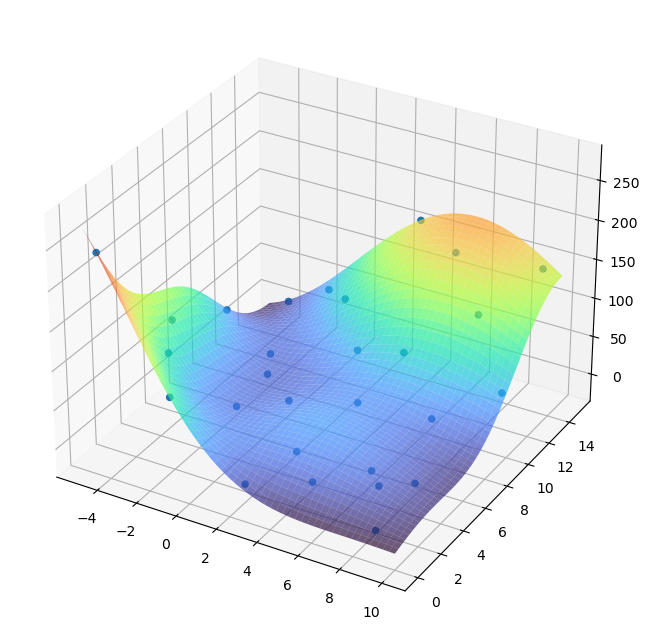

In [90]:
#zp = np.array([[gpr.predict([[xx1,xx2]])[0] for xx1 in x1] for xx2 in x2]) 
fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(1,1,1,projection='3d')

ax.scatter3D(np.array(tbl)[:,0],np.array(tbl)[:,1],tbyl,alpha=1)
ax.plot_surface(X1,X2,zp,cmap='turbo',alpha=0.7)

Text(0, 0.5, 'MSE')

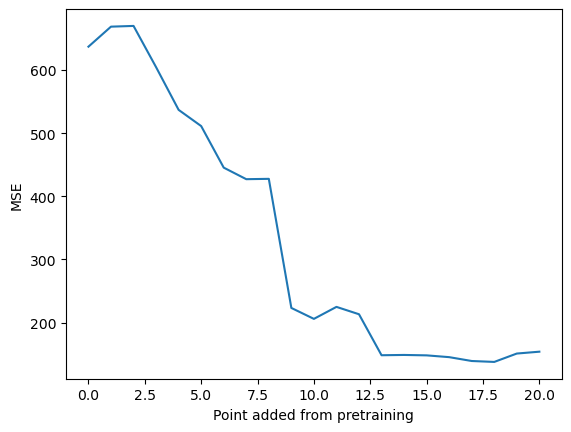

In [91]:
plt.plot(MSEs)
plt.xlabel('Point added from pretraining')
plt.ylabel('MSE')

In [92]:
# Add more candidates
for i in range(10):
    select_new_samples_single_episode(candl,tbl,tbyl,gpr)
    Yp = gpr.predict(Xt)
    mse = mean_squared_error(YT,Yp)

    MSEs.append(mse)

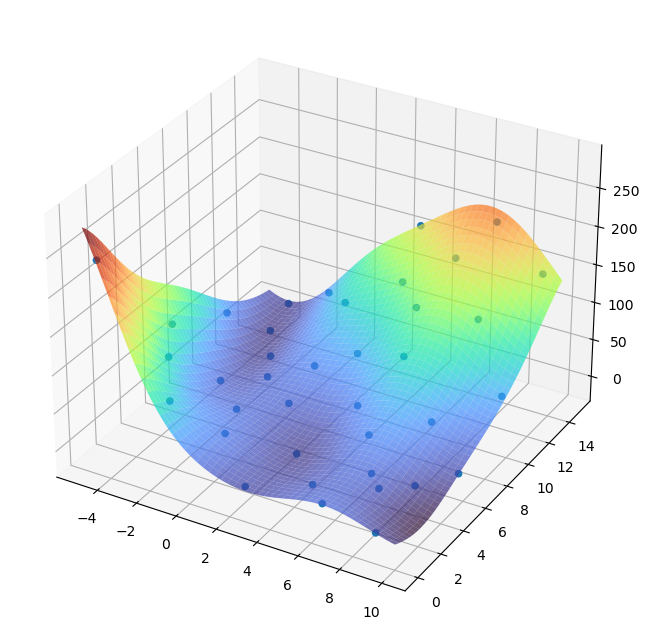

In [93]:
zp = np.array([[gpr.predict([[xx1,xx2]])[0] for xx1 in x1] for xx2 in x2]) 

fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(1,1,1,projection='3d')

ax.scatter3D(np.array(tbl)[:,0],np.array(tbl)[:,1],tbyl,alpha=1)
ax.plot_surface(X1,X2,zp,cmap='turbo',alpha=0.7)

Text(0, 0.5, 'MSE')

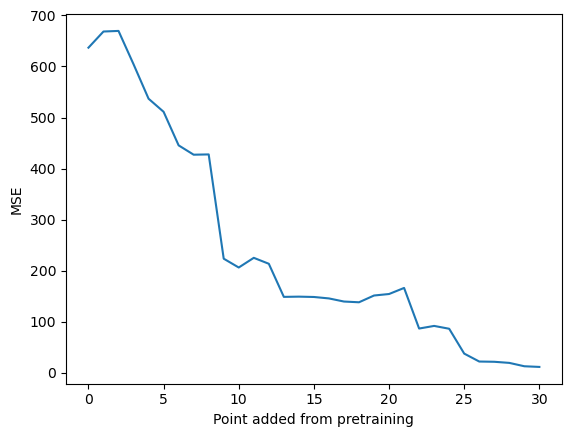

In [94]:
plt.plot(MSEs)
plt.xlabel('Point added from pretraining')
plt.ylabel('MSE')

In [95]:
gpr.kernel_

107**2 * RBF(length_scale=3.79)

Initial MSE:  1044.792056330538


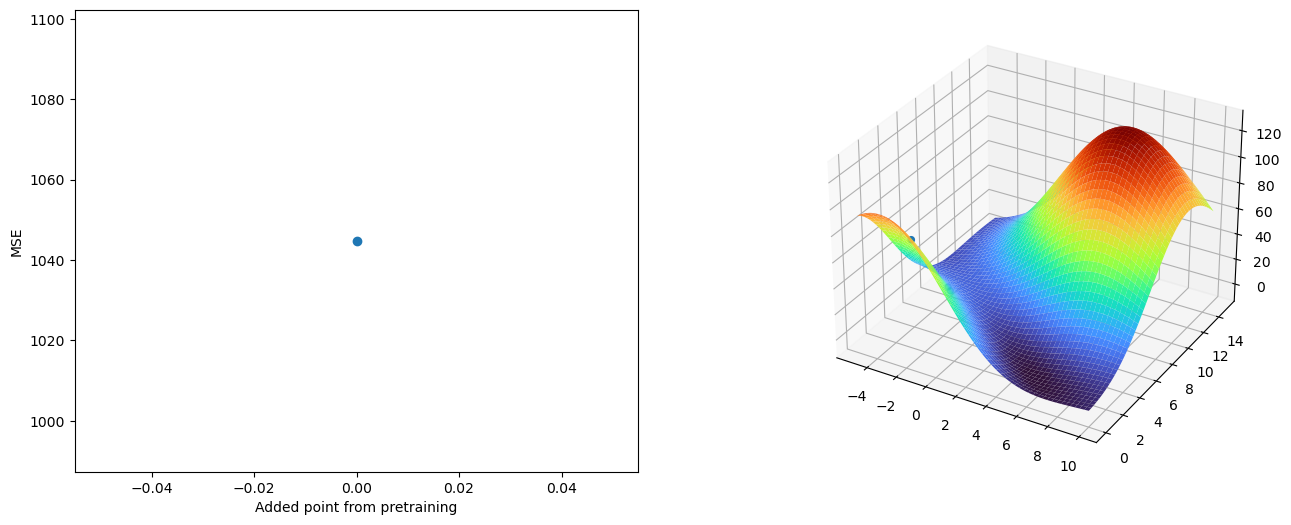

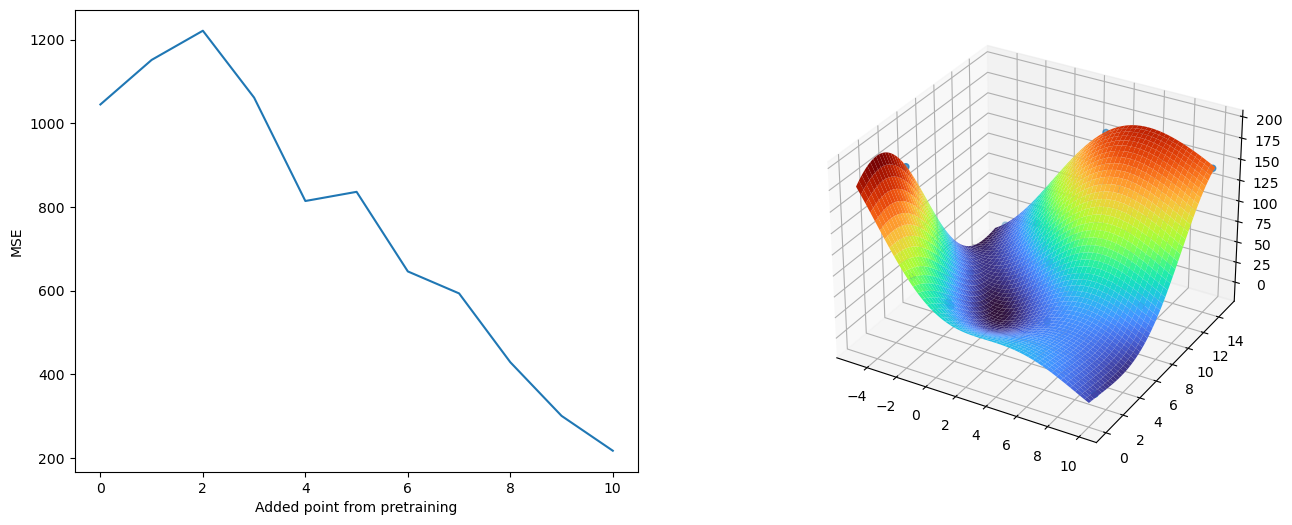

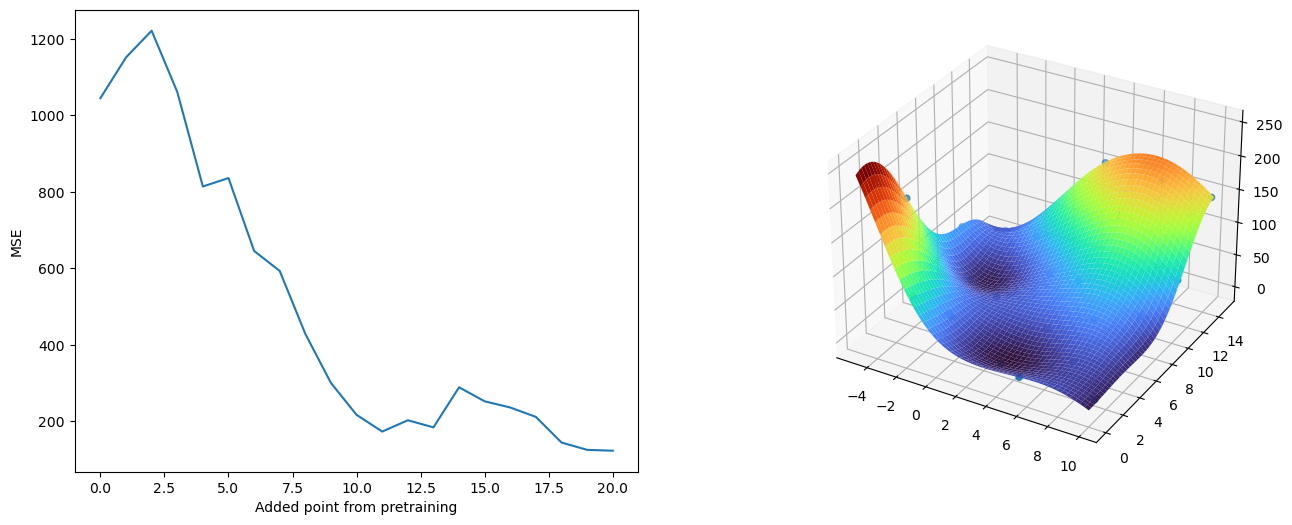

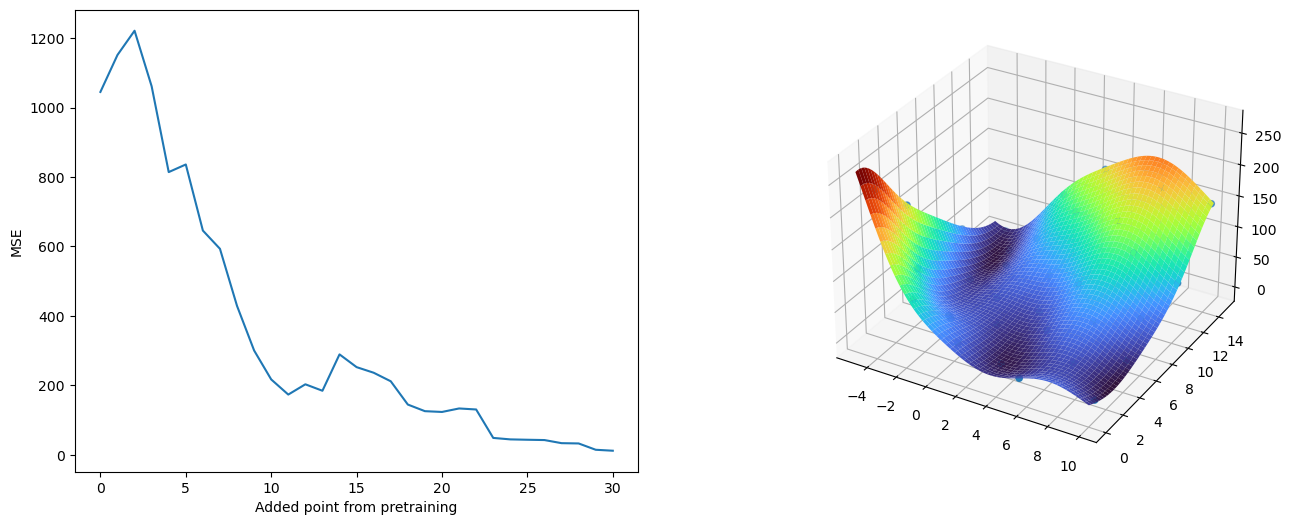

In [182]:
Mses, gprs, tbl, tbyl = test(select_new_samples_single_episode,3,4,plotting=True)

# Greedy Sampling in two dimensions

In [121]:
def accum(x):
    return 0.5*(1+sp.erf(x/np.sqrt(2)))

def singleStepGS_xy(candidates, x_init, y_init, model):
    Gss = [GS_x(candidate,x_init) for candidate in candidates]
    Ypreds = model.predict(np.array(candidates))
    Gyy = [GS_x(candidate,y_init) for candidate in Ypreds]
    cand = np.argmax(np.array(Gss)*np.array(Gyy))
    x_init.append(candidates[cand])
    y_init.append(Brannin(candidates[cand][0],candidates[cand][1]))
    candidates.pop(cand)
    model.fit(np.array(x_init),np.array(y_init))
    return None

In [128]:
Mses, gprs = test(singleStepGS_xy,1)

Initial MSE:  636.8889149781771


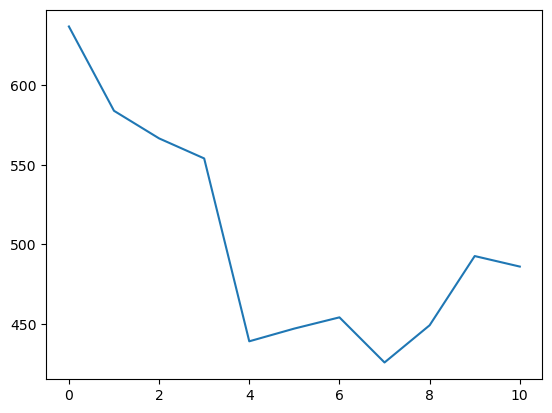

In [129]:
plt.plot(Mses)

Initial MSE:  1044.792056330538


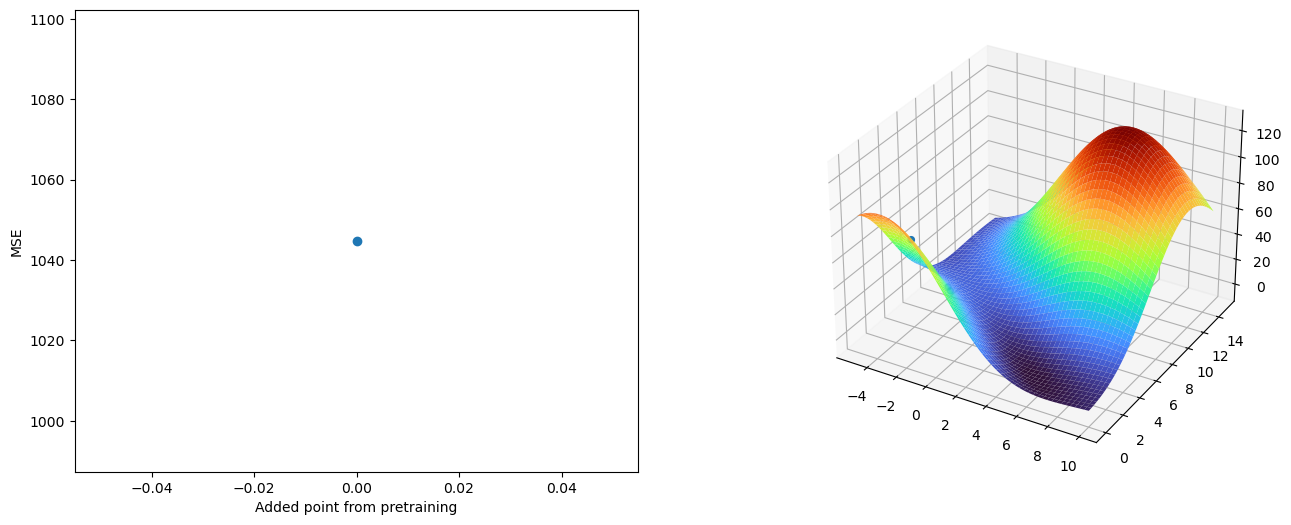

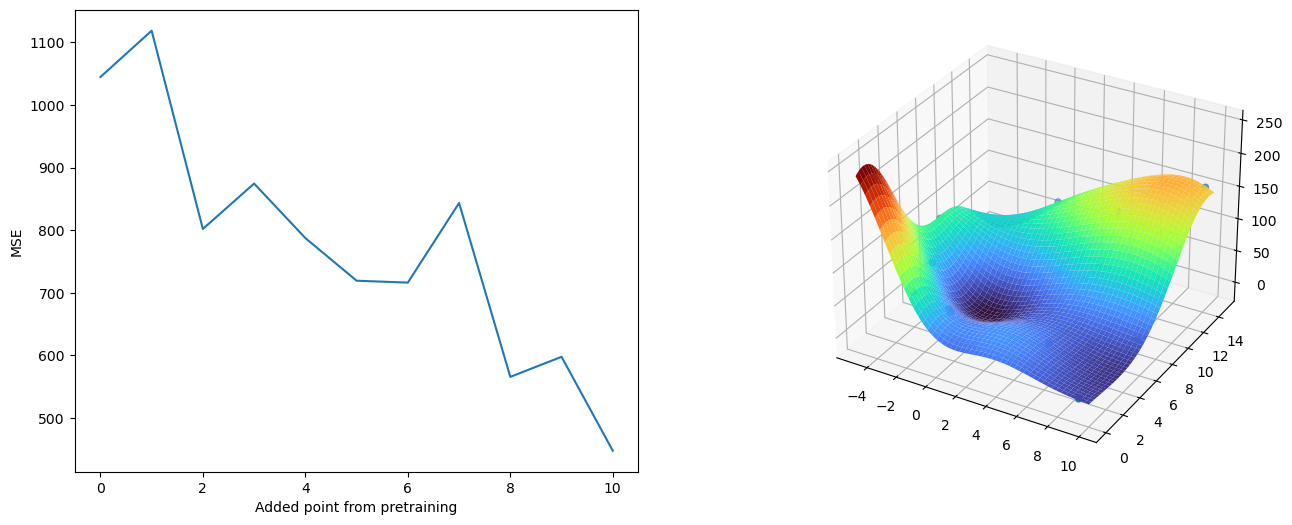

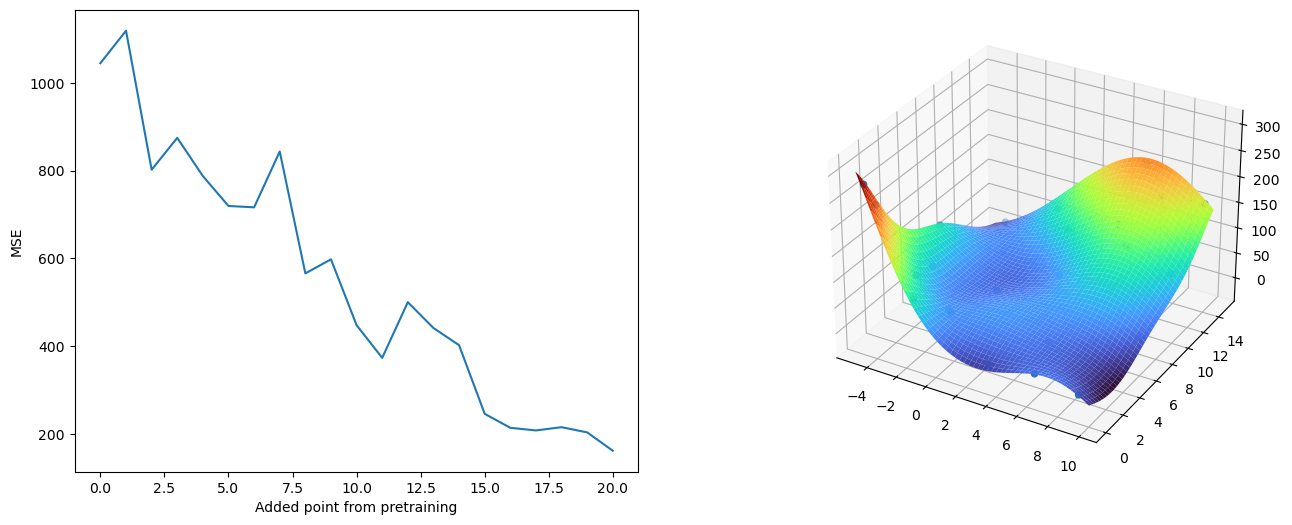

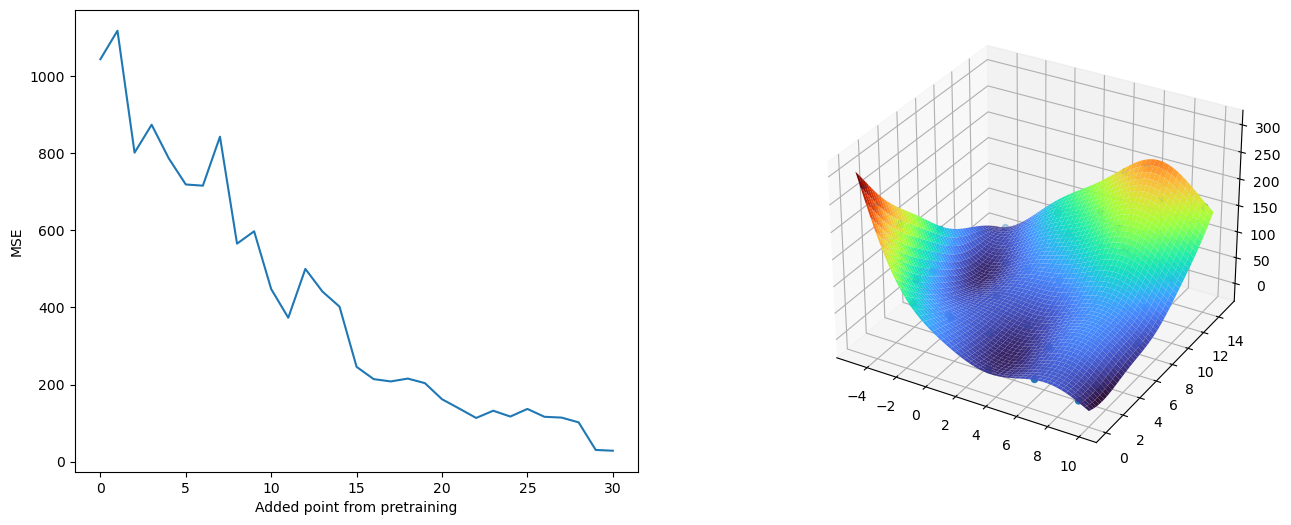

In [181]:
Mses, gprs, tbl, tbyl = test(singleStepGS_xy,3,4,plotting=True)

In [184]:
Mses_xy, gprs_xy, tbl_xy, tbyl_xy = test(singleStepGS_xy,3,4)

Initial MSE:  1044.792056330538


In [185]:
Mses_xy[-1]

28.05885440865385

In [186]:
Mses_x, gprs_x, tbl_x, tbyl_x = test(select_new_samples_single_episode,3,4)

Initial MSE:  1044.792056330538


# A random point selection control

In [188]:
def singleRandom(candidates, x_init, y_init, model):
    cand = np.random.randint(0,len(candidates))
    x_init.append(candidates[cand])
    y_init.append(Brannin(candidates[cand][0],candidates[cand][1]))
    candidates.pop(cand)
    model.fit(np.array(x_init),np.array(y_init))
    return None

Initial MSE:  1044.792056330538


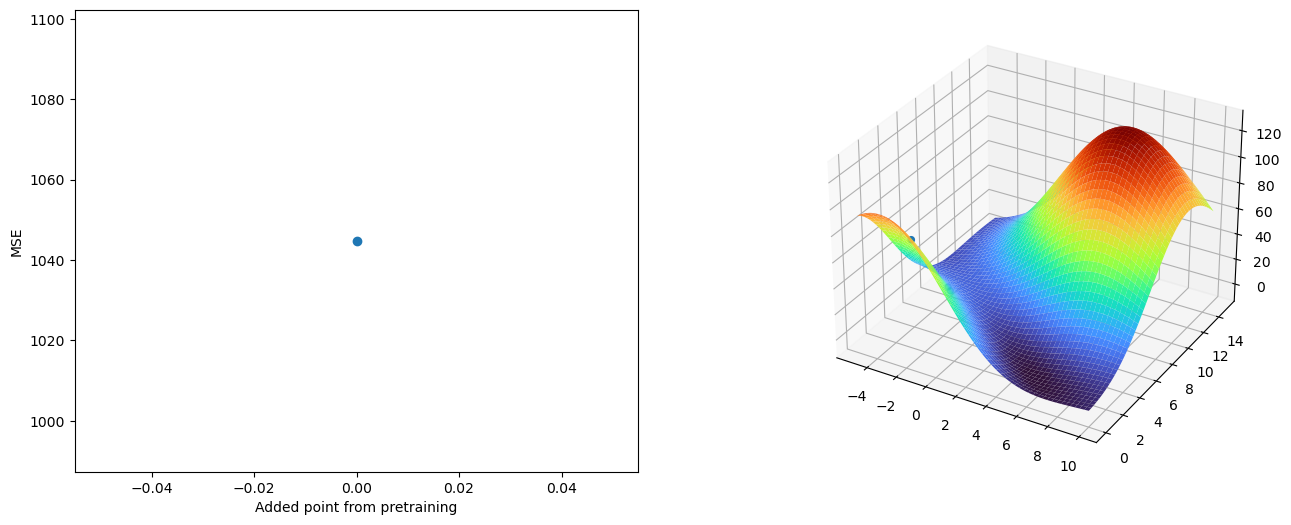

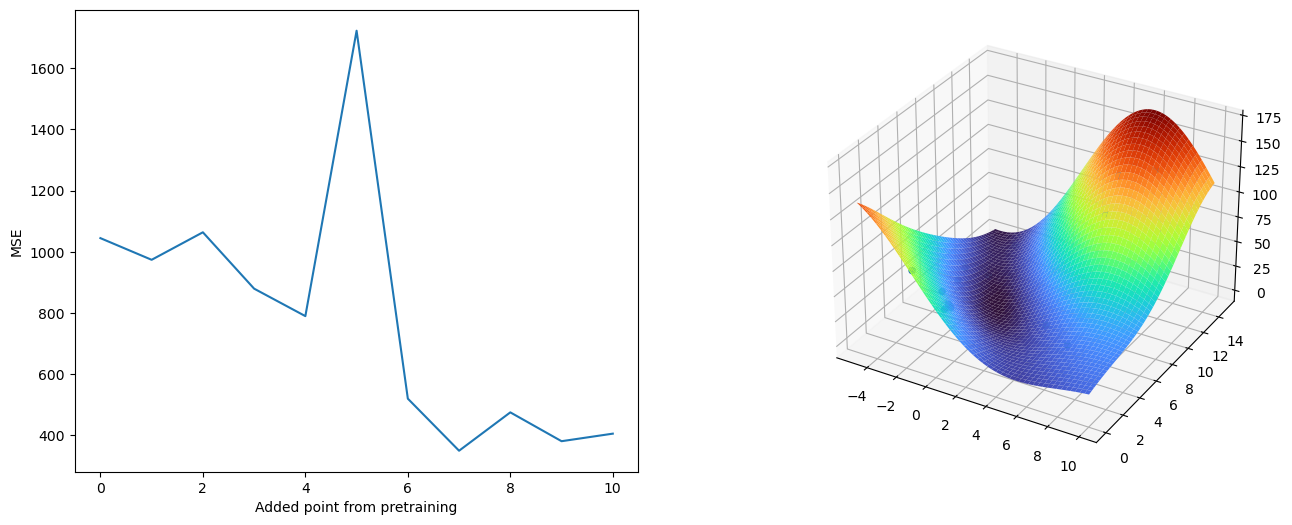

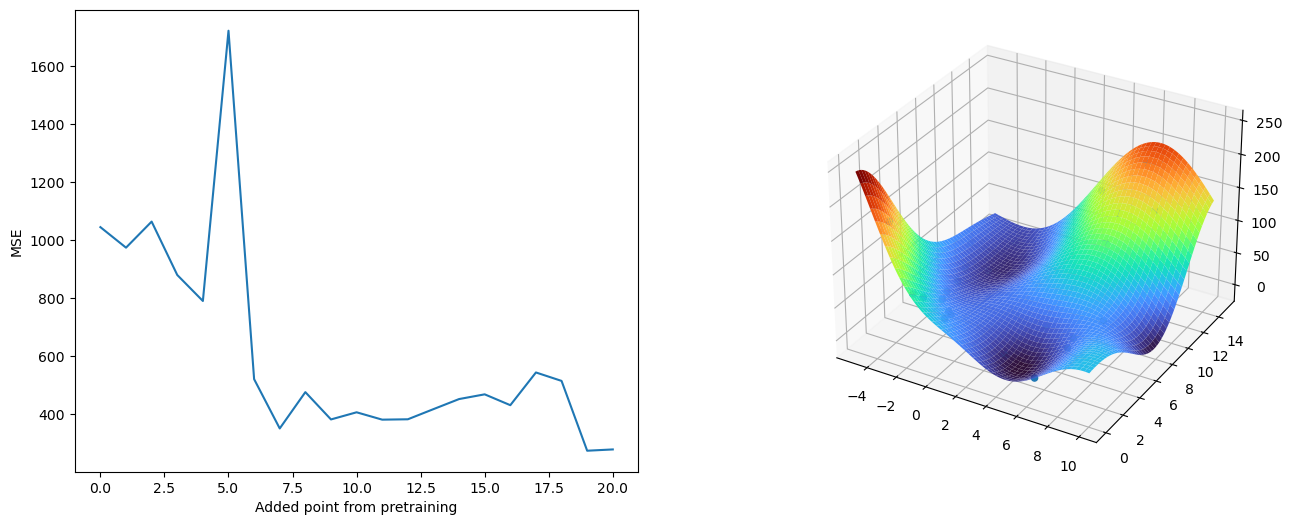

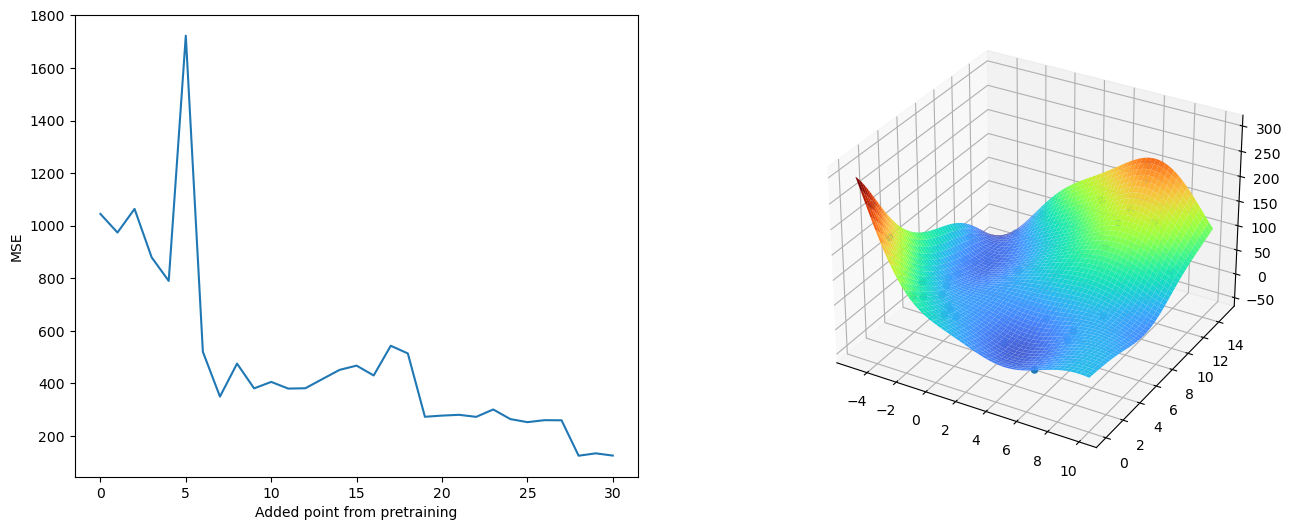

In [189]:
Mses_r, gprs_r, tbl_r, tbyl_r = test(singleRandom,3,4,plotting=True)

# Greedy sampling based on uncertainty

In [13]:

# Determine on a model what point from the list of candidates to add
def select_new_samples_variance(candidates, x_init, y_init, model):
    y,Gss = model.predict(candidates,return_std=True)
    cand = np.argmax(Gss)
    x_init.append(candidates[cand])
    y_init.append(Brannin(candidates[cand][0],candidates[cand][1]))
    candidates.pop(cand)
    model.fit(np.array(x_init),np.array(y_init))
    return None

Initial MSE:  1044.792056330538


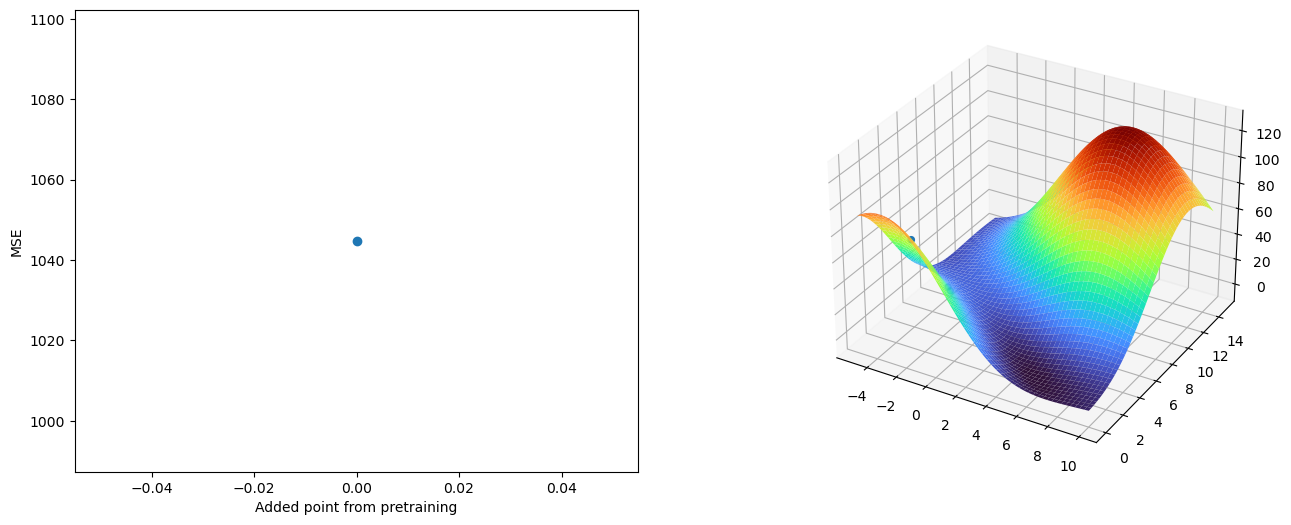

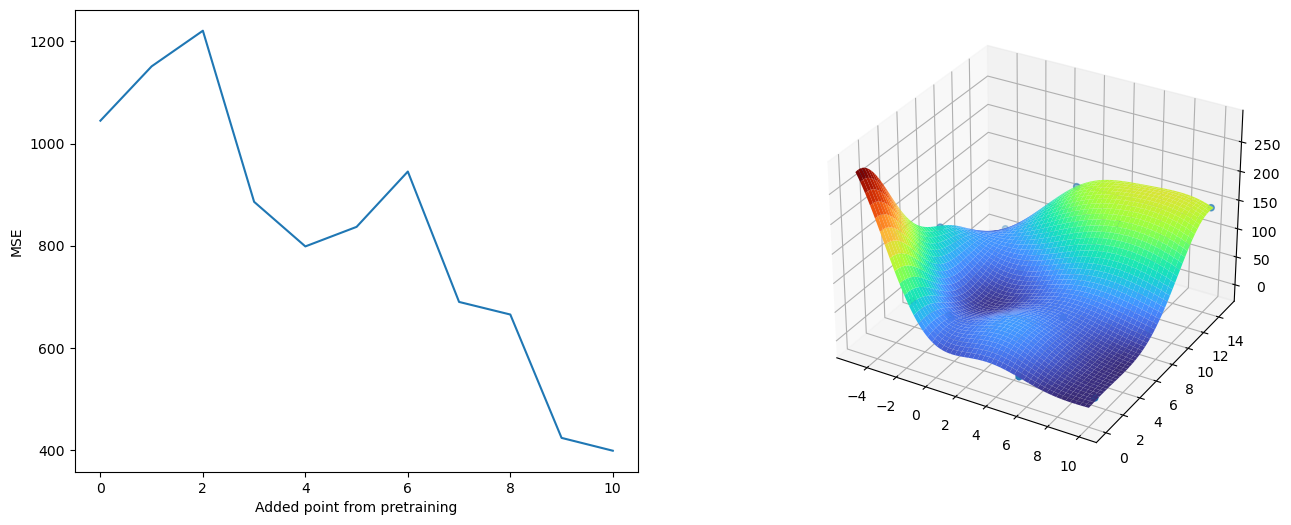

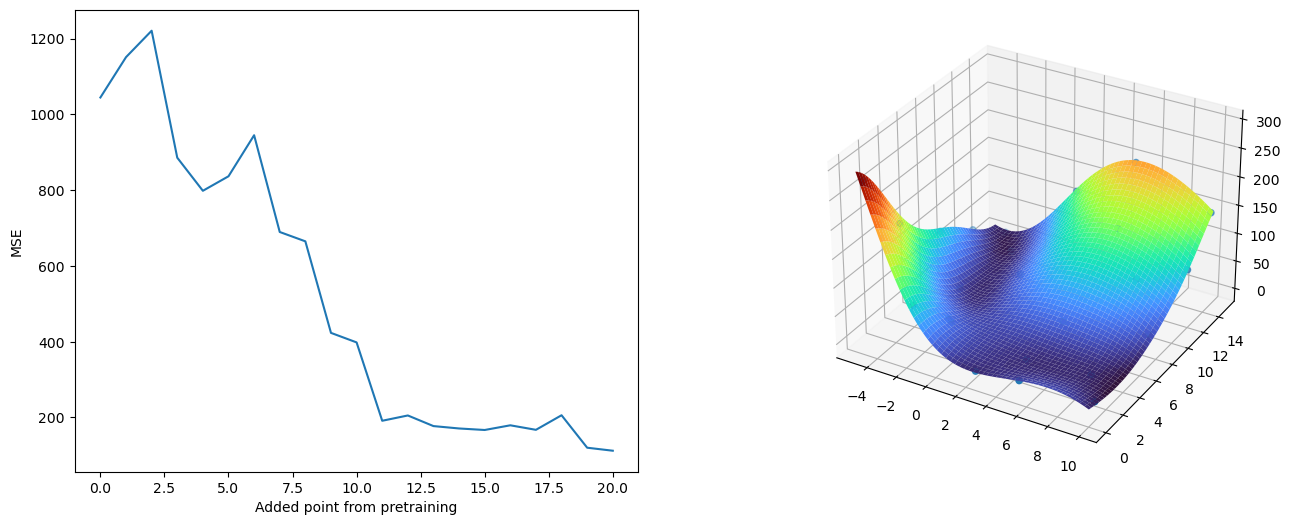

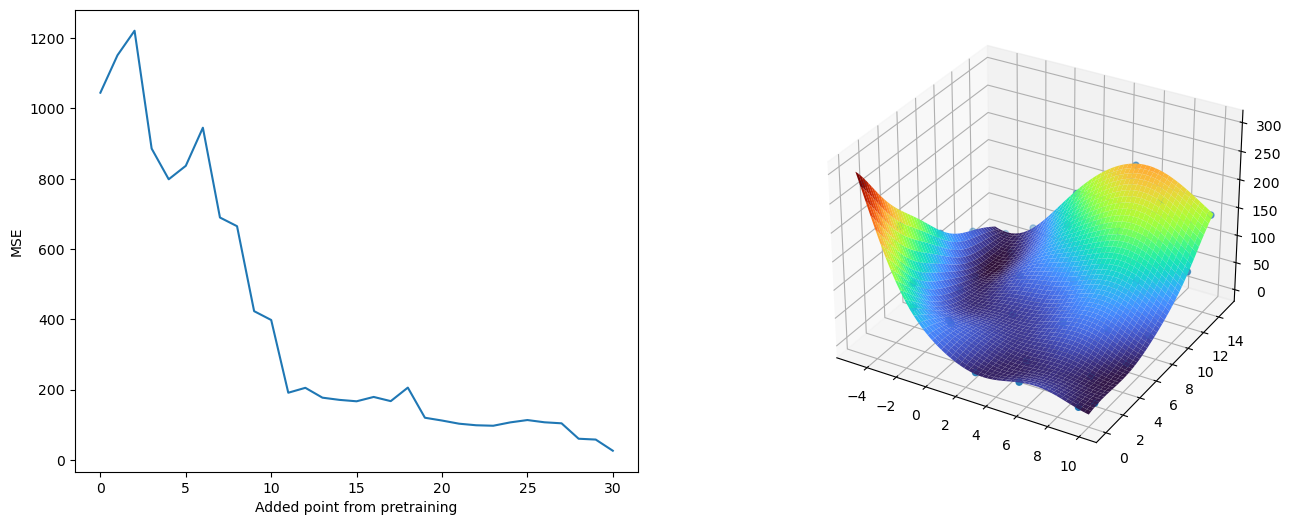

In [14]:
Mses_r, gprs_r, tbl_r, tbyl_r = test(select_new_samples_variance,3,4,plotting=True)

In [16]:
Mses_r[0],Mses_r[-1]

(1044.792056330538, 26.366646701345896)

# Very large data set for training in a single shot

In [13]:
# Data generation

# 
tb = np.random.random((900,2))*15
tb[:,0] = tb[:,0]-5

Xt = []
for xx1 in x1:
    for xx2 in x2:
        Xt.append([xx1,xx2])
        
Xt = np.array(Xt)
YT = np.array([Brannin(xx1,xx2) for xx1,xx2 in Xt])

tby = np.array([Brannin(xx1,xx2) for xx1,xx2 in tb])

In [14]:
Brannin(*tb[0])

48.13682197426475

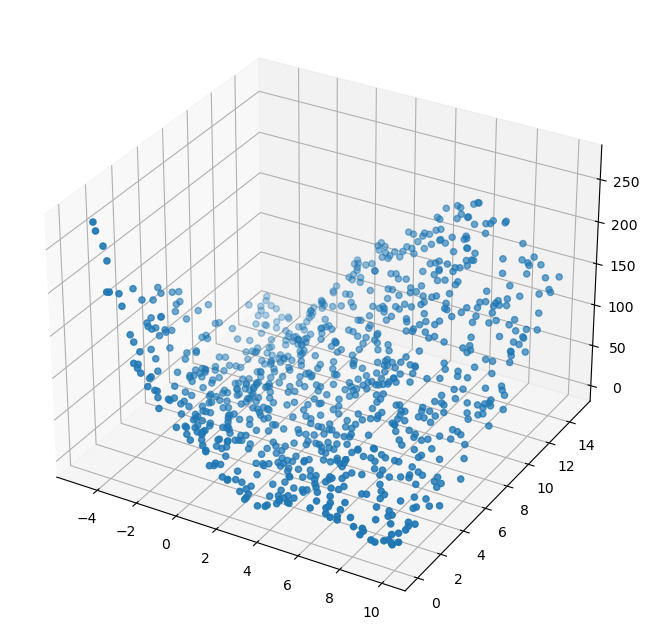

In [15]:
fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(1,1,1,projection='3d')
ax.scatter3D(tb[:,0],tb[:,1],tby)

In [31]:
kernel = 1.0 * RBF(length_scale=1e1, length_scale_bounds=(5e-1,1e2))
gpr = GaussianProcessRegressor(kernel=kernel,alpha=2.0)
gpr.fit(tb,tby)

GaussianProcessRegressor(alpha=2.0, kernel=1**2 * RBF(length_scale=10))

In [33]:
Yp = gpr.predict(Xt)

In [34]:
mean_squared_error(YT,Yp)

0.03116334887921087

In [35]:
zp = np.array([[gpr.predict([[xx1,xx2]])[0] for xx1 in x1] for xx2 in x2]) 

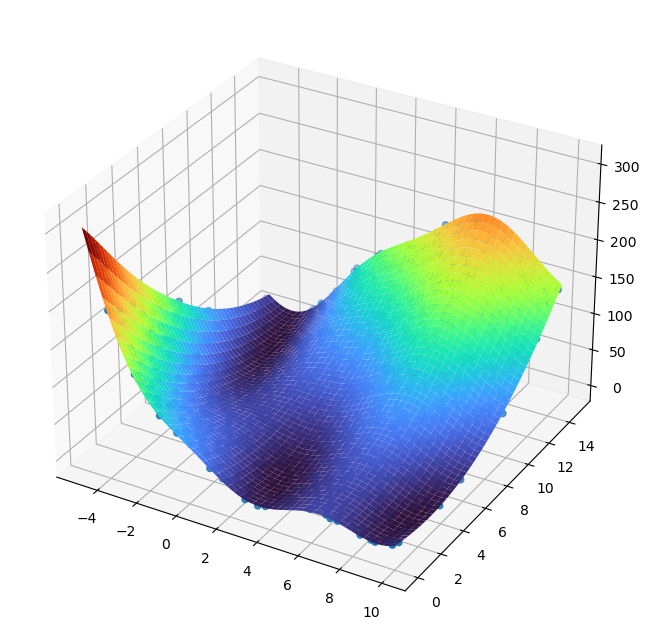

In [36]:
fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(1,1,1,projection='3d')
ax.plot_surface(X1,X2,zp,cmap='turbo')
ax.scatter3D(tb[:,0],tb[:,1],tby)

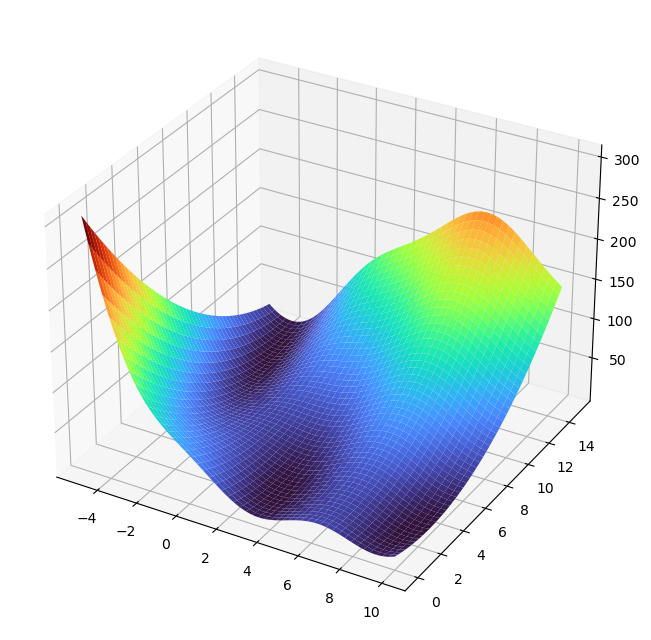

In [37]:
fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(1,1,1,projection='3d')
ax.plot_surface(X1,X2,z,cmap='turbo')